<a href="https://colab.research.google.com/github/Luke-Williams-01/Luke-Williams-01/blob/main/ICRARproject2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Imports
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.integrate import simps
from scipy import integrate
from scipy import stats, interpolate
from astropy.cosmology import FlatLambdaCDM
from astropy.io import fits

1) Cross-matching the xCOLDGASS sample with the xGASS galaxies to investigate the molecular hydrogen, H2 in the galaxy. This is in the optical region of a galaxy and therefore will not require the process used for HI.

In [2]:
hdulist = fits.open('xGASSCOLD_matched_innHI.fits')
hdu = hdulist[1].data
cols = hdulist[1].columns
# Importing data into arrays
GASS = hdu['GASS']
FLAG_CO = hdu['FLAG_CO']
lgMH2 = hdu['LOGMH2']
limlgMH2 = hdu['LIM_LOGMH2']
lgMH2_2_Ms = hdu['LOGMH2MS']
lgMSTAR = hdu['LOGMSTAR']
SFRbest = hdu['SFR_best']
NUVr = hdu['NUVr_1']
lgMuST = hdu['lgmust']
lgMHI_in = hdu['lgMHI_2Reff']
lgMHI_gl = hdu['lgMHI_global']
B2TM = hdu['B2T_M']
HIsrc = hdu['HIsource']
lgSFRbest = np.log10(SFRbest)
lgsSFR = np.log10((SFRbest) / (10**lgMSTAR))
print('Starting length of the dataset is', len(FLAG_CO))

Starting length of the dataset is 383


In [3]:
# Checking whether any of the galaxies in the dataset are missing important values
print('Data without H2 mass values:', np.where((lgMH2 < 0) & (limlgMH2 < 0))[0], np.where(np.isnan(lgMH2))[0], np.where(np.isnan(limlgMH2))[0])
print('Data without stellar mass values:', np.where(lgMSTAR < 0)[0], np.where(np.isnan(lgMSTAR))[0])
print('Data without NUV-r values:', np.where(NUVr < 0)[0], np.where(np.isnan(NUVr))[0])
print('Data without stellar mass density values:', np.where(lgMuST < 0)[0], np.where(np.isnan(lgMuST))[0])

Data without H2 mass values: [] [] []
Data without stellar mass values: [] []
Data without NUV-r values: [] []
Data without stellar mass density values: [] []


In [4]:
# Need to separate the H2 data into the detections and the non-detection upper limits
# We can use the CO flag for this, 1 = H2 detection, 2 = no H2 detection (upper limit only)
# H2 detections
lgMH2_det = np.delete(lgMH2, (np.where(FLAG_CO > 1)))
lgMSTAR_det = np.delete(lgMSTAR, (np.where(FLAG_CO > 1)))
lgSFRbest_det = np.delete(lgSFRbest, (np.where(FLAG_CO > 1)))
NUVr_det = np.delete(NUVr, (np.where(FLAG_CO > 1)))
lgMuST_det = np.delete(lgMuST, (np.where(FLAG_CO > 1)))
lgsSFR_det = np.delete(lgsSFR, (np.where(FLAG_CO > 1)))
lgMHI_in_det = np.delete(lgMHI_in, (np.where(FLAG_CO > 1)))
lgMHI_gl_det = np.delete(lgMHI_gl, (np.where(FLAG_CO > 1)))
# H2 non-detections
limlgMH2_ndet = np.delete(limlgMH2, (np.where(FLAG_CO < 2)))
lgMSTAR_ndet = np.delete(lgMSTAR, (np.where(FLAG_CO < 2)))
lgSFRbest_ndet = np.delete(lgSFRbest, (np.where(FLAG_CO < 2)))
NUVr_ndet = np.delete(NUVr, (np.where(FLAG_CO < 2)))
lgMuST_ndet = np.delete(lgMuST, (np.where(FLAG_CO < 2)))
lgsSFR_ndet = np.delete(lgsSFR, (np.where(FLAG_CO < 2)))
lgMHI_in_ndet = np.delete(lgMHI_in, (np.where(FLAG_CO < 2)))
lgMHI_gl_ndet = np.delete(lgMHI_gl, (np.where(FLAG_CO < 2)))

2) Plotting how the H2 changes with stellar mass and SFR

In [5]:
# Finding the running median of the galaxies for H2
# Arrays for the bins
H2bins = np.linspace(9, 11.9, 10)
H2bins2 = np.linspace(-1.9, 1.5, 10)

# Array of zeroes to store the median of each bin
mH2_1 = np.zeros(len(H2bins))
H2median1 = np.zeros(len(H2bins))
H2MAD1 = np.zeros(len(H2bins))

mH2_2 = np.zeros(len(H2bins2))
H2median2 = np.zeros(len(H2bins2))
H2MAD2 = np.zeros(len(H2bins2))

# Using a for loop to iterate over the median values for each of the bins
for i in range(len(H2bins) -1):
  # Median and MAD for H2 of galaxies against stellar mass
  H2median1[i] = np.median(lgMH2_det[np.where((lgMSTAR_det >= H2bins[i]) & (lgMSTAR_det <= H2bins[i+1]))])
  H2MAD1[i] = stats.median_abs_deviation(lgMH2_det[np.where((lgMSTAR_det >= H2bins[i]) & (lgMSTAR_det <= H2bins[i+1]))])
  mH2_1[i] = H2median1[i]

  # Median and MAD for H2 of galaxies against SFR
  H2median2[i] = np.median(lgMH2_det[np.where((lgSFRbest_det >= H2bins2[i]) & (lgSFRbest_det <= H2bins2[i+1]))])
  H2MAD2[i] = stats.median_abs_deviation(lgMH2_det[np.where((lgSFRbest_det >= H2bins2[i]) & (lgSFRbest_det <= H2bins2[i+1]))])
  mH2_2[i] = H2median2[i]

# Working out the upper and lower bounds of the median absolute deviation
H2pMAD1 = mH2_1 + H2MAD1
H2nMAD1 = mH2_1 - H2MAD1
H2pMAD2 = mH2_2 + H2MAD2
H2nMAD2 = mH2_2 - H2MAD2

/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in true_divide
  ret = ret.dtype.type(ret / rcount)


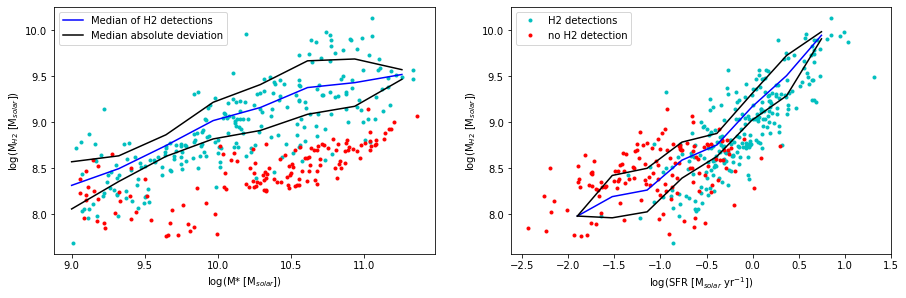

In [6]:
# Plotting the relations between the H2 mass in the galaxy and stellar mass as well as the Star formation rate
plt.figure(figsize = (15,10))
# H2 mass against Stellar mass
plt.subplot(221)
plt.plot(lgMSTAR_det, lgMH2_det, 'c.')
plt.plot(lgMSTAR_ndet, limlgMH2_ndet, 'r.')
plt.plot(H2bins[:-2], mH2_1[:-2], 'b-', label = 'Median of H2 detections')
plt.plot(H2bins[:-2], H2pMAD1[:-2], 'k-', label = 'Median absolute deviation')
plt.plot(H2bins[:-2], H2nMAD1[:-2], 'k-')
plt.xlabel('log(M* [M$_{solar}$])')
plt.ylabel('log(M$_{H2}$ [M$_{solar}$])')
plt.legend(loc='upper left')

# H2 mass against Star formation rate
plt.subplot(222)
plt.plot(lgSFRbest_det, lgMH2_det, 'c.', label= 'H2 detections')
plt.plot(lgSFRbest_ndet, limlgMH2_ndet, 'r.', label= 'no H2 detection')
plt.plot(H2bins2[:-2], mH2_2[:-2], 'b-')
plt.plot(H2bins2[:-2], H2pMAD2[:-2], 'k-')
plt.plot(H2bins2[:-2], H2nMAD2[:-2], 'k-')
plt.xlabel('log(SFR [M$_{solar}$ yr$^{-1}$])')
plt.ylabel('log(M$_{H2}$ [M$_{solar}$])')
plt.legend(loc='upper left');

3) Comparing how the H2 mass changes with various stellar properties, plotted with how the global HI mass changes and how the HI mass inside the optical region changes

In [7]:
# Finding the running median of the galaxies in the sample for the HI global
# Arrays for the bins
HIglbins_Mstar = np.linspace(9, 11.5, 10)
HIglbins_NUVr = np.linspace(1, 5.5, 10)
HIglbins_sSFR = np.linspace(-11.5, -9.5, 10)
HIglbins_Must = np.linspace(7.5, 10, 10)

# Array of zeroes to store the median of each bin
MHIgl_Mstar = np.zeros(len(HIglbins_Mstar))
HIglmedian_Mstar = np.zeros(len(HIglbins_Mstar))
HIglMAD_Mstar = np.zeros(len(HIglbins_Mstar))

MHIgl_NUVr = np.zeros(len(HIglbins_NUVr))
HIglmedian_NUVr = np.zeros(len(HIglbins_NUVr))
HIglMAD_NUVr = np.zeros(len(HIglbins_NUVr))

MHIgl_sSFR = np.zeros(len(HIglbins_sSFR))
HIglmedian_sSFR = np.zeros(len(HIglbins_sSFR))
HIglMAD_sSFR = np.zeros(len(HIglbins_sSFR))

MHIgl_Must = np.zeros(len(HIglbins_Must))
HIglmedian_Must = np.zeros(len(HIglbins_Must))
HIglMAD_Must = np.zeros(len(HIglbins_Must))

In [8]:
# Using a for loop to iterate over the median values for each of the bins
for i in range(len(HIglbins_Mstar) -1):
  # Median and MAD for the Mstar graph
  HIglmedian_Mstar[i] = np.median(lgMHI_gl_det[np.where((lgMSTAR_det >= HIglbins_Mstar[i]) & (lgMSTAR_det <= HIglbins_Mstar[i+1]))])
  HIglMAD_Mstar[i] = stats.median_abs_deviation(lgMHI_gl_det[np.where((lgMSTAR_det >= HIglbins_Mstar[i]) & (lgMSTAR_det <= HIglbins_Mstar[i+1]))])
  MHIgl_Mstar[i] = HIglmedian_Mstar[i]

  # Median and MAD for the NUV-r graph
  HIglmedian_NUVr[i] = np.median(lgMHI_gl_det[np.where((NUVr_det >= HIglbins_NUVr[i]) & (NUVr_det <= HIglbins_NUVr[i+1]))])
  HIglMAD_NUVr[i] = stats.median_abs_deviation(lgMHI_gl_det[np.where((NUVr_det >= HIglbins_NUVr[i]) & (NUVr_det <= HIglbins_NUVr[i+1]))])
  MHIgl_NUVr[i] = HIglmedian_NUVr[i]

  # Median and MAD for the sSFR graph
  HIglmedian_sSFR[i] = np.median(lgMHI_gl_det[np.where((lgsSFR_det >= HIglbins_sSFR[i]) & (lgsSFR_det <= HIglbins_sSFR[i+1]))])
  HIglMAD_sSFR[i] = stats.median_abs_deviation(lgMHI_gl_det[np.where((lgsSFR_det >= HIglbins_sSFR[i]) & (lgsSFR_det <= HIglbins_sSFR[i+1]))])
  MHIgl_sSFR[i] = HIglmedian_sSFR[i]

  #Median and MAD for the Must graph
  HIglmedian_Must[i] = np.median(lgMHI_gl_det[np.where((lgMuST_det >= HIglbins_Must[i]) & (lgMuST_det <= HIglbins_Must[i+1]))])
  HIglMAD_Must[i] = stats.median_abs_deviation(lgMHI_gl_det[np.where((lgMuST_det >= HIglbins_Must[i]) & (lgMuST_det <= HIglbins_Must[i+1]))])
  MHIgl_Must[i] = HIglmedian_Must[i]

# Working out the upper and lower bounds of the median absolute deviation
# Mstar graph median bounds
HIglpMAD_Mstar = MHIgl_Mstar + HIglMAD_Mstar
HIglnMAD_Mstar = MHIgl_Mstar - HIglMAD_Mstar
# NUV-r graph median bounds
HIglpMAD_NUVr = MHIgl_NUVr + HIglMAD_NUVr
HIglnMAD_NUVr = MHIgl_NUVr - HIglMAD_NUVr
# sSFR graph median bounds
HIglpMAD_sSFR = MHIgl_sSFR + HIglMAD_sSFR
HIglnMAD_sSFR = MHIgl_sSFR - HIglMAD_sSFR
# Must graph median bounds
HIglpMAD_Must = MHIgl_Must + HIglMAD_Must
HIglnMAD_Must = MHIgl_Must - HIglMAD_Must

In [9]:
# Finding the running median of the galaxies in the sample for the HI inner
# Arrays for the bins
HIinbins_Mstar = np.linspace(9, 11.5, 10)
HIinbins_NUVr = np.linspace(1, 5.5, 10)
HIinbins_sSFR = np.linspace(-11.5, -9.5, 10)
HIinbins_Must = np.linspace(7.5, 10, 10)

# Array of zeroes to store the median of each bin
MHIin_Mstar = np.zeros(len(HIinbins_Mstar))
HIinmedian_Mstar = np.zeros(len(HIinbins_Mstar))
HIinMAD_Mstar = np.zeros(len(HIinbins_Mstar))

MHIin_NUVr = np.zeros(len(HIinbins_NUVr))
HIinmedian_NUVr = np.zeros(len(HIinbins_NUVr))
HIinMAD_NUVr = np.zeros(len(HIinbins_NUVr))

MHIin_sSFR = np.zeros(len(HIinbins_sSFR))
HIinmedian_sSFR = np.zeros(len(HIinbins_sSFR))
HIinMAD_sSFR = np.zeros(len(HIinbins_sSFR))

MHIin_Must = np.zeros(len(HIinbins_Must))
HIinmedian_Must = np.zeros(len(HIinbins_Must))
HIinMAD_Must = np.zeros(len(HIinbins_Must))

In [10]:
# Using a for loop to iterate over the median values for each of the bins
for i in range(len(HIinbins_Mstar) -1):
  # Median and MAD for the Mstar graph
  HIinmedian_Mstar[i] = np.median(lgMHI_in_det[np.where((lgMSTAR_det >= HIinbins_Mstar[i]) & (lgMSTAR_det <= HIinbins_Mstar[i+1]))])
  HIinMAD_Mstar[i] = stats.median_abs_deviation(lgMHI_in_det[np.where((lgMSTAR_det >= HIinbins_Mstar[i]) & (lgMSTAR_det <= HIinbins_Mstar[i+1]))])
  MHIin_Mstar[i] = HIinmedian_Mstar[i]

  # Median and MAD for the NUV-r graph
  HIinmedian_NUVr[i] = np.median(lgMHI_in_det[np.where((NUVr_det >= HIinbins_NUVr[i]) & (NUVr_det <= HIinbins_NUVr[i+1]))])
  HIinMAD_NUVr[i] = stats.median_abs_deviation(lgMHI_in_det[np.where((NUVr_det >= HIinbins_NUVr[i]) & (NUVr_det <= HIinbins_NUVr[i+1]))])
  MHIin_NUVr[i] = HIinmedian_NUVr[i]

  # Median and MAD for the sSFR graph
  HIinmedian_sSFR[i] = np.median(lgMHI_in_det[np.where((lgsSFR_det >= HIinbins_sSFR[i]) & (lgsSFR_det <= HIinbins_sSFR[i+1]))])
  HIinMAD_sSFR[i] = stats.median_abs_deviation(lgMHI_in_det[np.where((lgsSFR_det >= HIinbins_sSFR[i]) & (lgsSFR_det <= HIinbins_sSFR[i+1]))])
  MHIin_sSFR[i] = HIinmedian_sSFR[i]
  
  #Median and MAD for the Must graph
  HIinmedian_Must[i] = np.median(lgMHI_in_det[np.where((lgMuST_det >= HIinbins_Must[i]) & (lgMuST_det <= HIinbins_Must[i+1]))])
  HIinMAD_Must[i] = stats.median_abs_deviation(lgMHI_in_det[np.where((lgMuST_det >= HIinbins_Must[i]) & (lgMuST_det <= HIinbins_Must[i+1]))])
  MHIin_Must[i] = HIinmedian_Must[i]

# Working out the upper and lower bounds of the median absolute deviation
# Mstar graph median bounds
HIinpMAD_Mstar = MHIin_Mstar + HIinMAD_Mstar
HIinnMAD_Mstar = MHIin_Mstar - HIinMAD_Mstar
# NUV-r graph median bounds
HIinpMAD_NUVr = MHIin_NUVr + HIinMAD_NUVr
HIinnMAD_NUVr = MHIin_NUVr - HIinMAD_NUVr
# sSFR graph median bounds
HIinpMAD_sSFR = MHIin_sSFR + HIinMAD_sSFR
HIinnMAD_sSFR = MHIin_sSFR - HIinMAD_sSFR
# Must graph median bounds
HIinpMAD_Must = MHIin_Must + HIinMAD_Must
HIinnMAD_Must = MHIin_Must - HIinMAD_Must

In [11]:
# Finding the running median for the galaxies in the sample for H2
H2bins_Mstar = np.linspace(9, 11.5, 10)
H2bins_NUVr = np.linspace(1, 5.5, 10)
H2bins_sSFR = np.linspace(-11.5, -9.5, 10)
H2bins_Must = np.linspace(7.5, 10, 10)

# Array of zeroes to store the median of each bin
MH2_Mstar = np.zeros(len(H2bins_Mstar))
H2median_Mstar = np.zeros(len(H2bins_Mstar))
H2MAD_Mstar = np.zeros(len(H2bins_Mstar))

MH2_NUVr = np.zeros(len(H2bins_NUVr))
H2median_NUVr = np.zeros(len(H2bins_NUVr))
H2MAD_NUVr = np.zeros(len(H2bins_NUVr))

MH2_sSFR = np.zeros(len(H2bins_sSFR))
H2median_sSFR = np.zeros(len(H2bins_sSFR))
H2MAD_sSFR = np.zeros(len(H2bins_sSFR))

MH2_Must = np.zeros(len(H2bins_Must))
H2median_Must = np.zeros(len(H2bins_Must))
H2MAD_Must = np.zeros(len(H2bins_Must))

In [12]:
# Using a for loop to iterate over the median values for each of the bins
for i in range(len(H2bins_Mstar) -1):
  # Median and MAD for the Mstar graph
  H2median_Mstar[i] = np.median(lgMH2_det[np.where((lgMSTAR_det >= H2bins_Mstar[i]) & (lgMSTAR_det <= H2bins_Mstar[i+1]))])
  H2MAD_Mstar[i] = stats.median_abs_deviation(lgMH2_det[np.where((lgMSTAR_det >= H2bins_Mstar[i]) & (lgMSTAR_det <= H2bins_Mstar[i+1]))])
  MH2_Mstar[i] = H2median_Mstar[i]

  # Median and MAD for the NUV-r graph
  H2median_NUVr[i] = np.median(lgMH2_det[np.where((NUVr_det >= H2bins_NUVr[i]) & (NUVr_det <= H2bins_NUVr[i+1]))])
  H2MAD_NUVr[i] = stats.median_abs_deviation(lgMH2_det[np.where((NUVr_det >= H2bins_NUVr[i]) & (NUVr_det <= H2bins_NUVr[i+1]))])
  MH2_NUVr[i] = H2median_NUVr[i]

  # Median and MAD for the sSFR graph
  H2median_sSFR[i] = np.median(lgMH2_det[np.where((lgsSFR_det >= H2bins_sSFR[i]) & (lgsSFR_det <= H2bins_sSFR[i+1]))])
  H2MAD_sSFR[i] = stats.median_abs_deviation(lgMH2_det[np.where((lgsSFR_det >= H2bins_sSFR[i]) & (lgsSFR_det <= H2bins_sSFR[i+1]))])
  MH2_sSFR[i] = H2median_sSFR[i]
  
  #Median and MAD for the Must graph
  H2median_Must[i] = np.median(lgMH2_det[np.where((lgMuST_det >= H2bins_Must[i]) & (lgMuST_det <= H2bins_Must[i+1]))])
  H2MAD_Must[i] = stats.median_abs_deviation(lgMH2_det[np.where((lgMuST_det >= H2bins_Must[i]) & (lgMuST_det <= H2bins_Must[i+1]))])
  MH2_Must[i] = H2median_Must[i]

# Working out the upper and lower bounds of the median absolute deviation
# Mstar graph median bounds
H2pMAD_Mstar = MH2_Mstar + H2MAD_Mstar
H2nMAD_Mstar = MH2_Mstar - H2MAD_Mstar
# NUV-r graph median bounds
H2pMAD_NUVr = MH2_NUVr + H2MAD_NUVr
H2nMAD_NUVr = MH2_NUVr - H2MAD_NUVr
# sSFR graph median bounds
H2pMAD_sSFR = MH2_sSFR + H2MAD_sSFR
H2nMAD_sSFR = MH2_sSFR - H2MAD_sSFR
# Must graph median bounds
H2pMAD_Must = MH2_Must + H2MAD_Must
H2nMAD_Must = MH2_Must - H2MAD_Must

In [13]:
# Spearman correlation coefficient for each scatter (detections only)
# For HI (global):
# Mstar
R_HIgl_Mstar = stats.spearmanr(lgMSTAR_det, lgMHI_gl_det)
R_HIgl_Mstarall = stats.spearmanr(lgMSTAR, lgMHI_gl)
# MuStar
R_HIgl_MuST = stats.spearmanr(lgMuST_det, lgMHI_gl_det)
R_HIgl_MuSTall = stats.spearmanr(lgMuST, lgMHI_gl)
# NUVr
R_HIgl_NUVr = stats.spearmanr(NUVr_det, lgMHI_gl_det)
R_HIgl_NUVrall = stats.spearmanr(NUVr, lgMHI_gl)
# sSFR
R_HIgl_sSFR = stats.spearmanr(lgsSFR_det, lgMHI_gl_det)
R_HIgl_sSFRall = stats.spearmanr(lgsSFR, lgMHI_gl)

# For HI (inside)
# Mstar
R_HIin_Mstar = stats.spearmanr(lgMSTAR_det, lgMHI_in_det)
R_HIin_MStarall = stats.spearmanr(lgMSTAR, lgMHI_in)
# MuStar
R_HIin_MuST = stats.spearmanr(lgMuST_det, lgMHI_in_det)
R_HIin_MuSTall = stats.spearmanr(lgMuST, lgMHI_in)
# NUVr
R_HIin_NUVr = stats.spearmanr(NUVr_det, lgMHI_in_det)
R_HIin_NUVrall = stats.spearmanr(NUVr, lgMHI_in)
# sSFR
R_HIin_sSFR = stats.spearmanr(lgsSFR_det, lgMHI_in_det)
R_HIin_sSFRall = stats.spearmanr(lgsSFR, lgMHI_in)

# For H2
# Mstar
R_H2_Mstar = stats.spearmanr(lgMSTAR_det, lgMH2_det)
R_H2_Mstarall = stats.spearmanr(lgMSTAR, lgMH2)
# MuStar
R_H2_MuST = stats.spearmanr(lgMuST_det, lgMH2_det)
R_H2_MuSTall = stats.spearmanr(lgMuST, lgMH2)
# NUVr
R_H2_NUVr = stats.spearmanr(NUVr_det, lgMH2_det)
R_H2_NUVrall = stats.spearmanr(NUVr, lgMH2)
# sSFR
R_H2_sSFR = stats.spearmanr(lgsSFR_det, lgMH2_det)
R_H2_sSFRall = stats.spearmanr(lgsSFR, lgMH2)

In [14]:
print(R_HIgl_Mstarall[0], R_HIgl_MuSTall[0], R_HIgl_NUVrall[0], R_HIgl_sSFRall[0])
print(R_HIin_MStarall[0], R_HIin_MuSTall[0], R_HIin_NUVrall[0], R_HIin_sSFRall[0])
print(R_H2_Mstarall[0], R_H2_MuSTall[0], R_H2_NUVrall[0], R_H2_sSFRall[0])

0.3381952466879446 -0.11805405041160157 -0.4403410199921524 0.3574603958504136
0.5152825710267958 -0.03982984159459204 -0.23365027906766683 0.14898333800390964
0.22604451669666456 -0.13867491897844442 -0.39396848980252547 0.4569920294399481


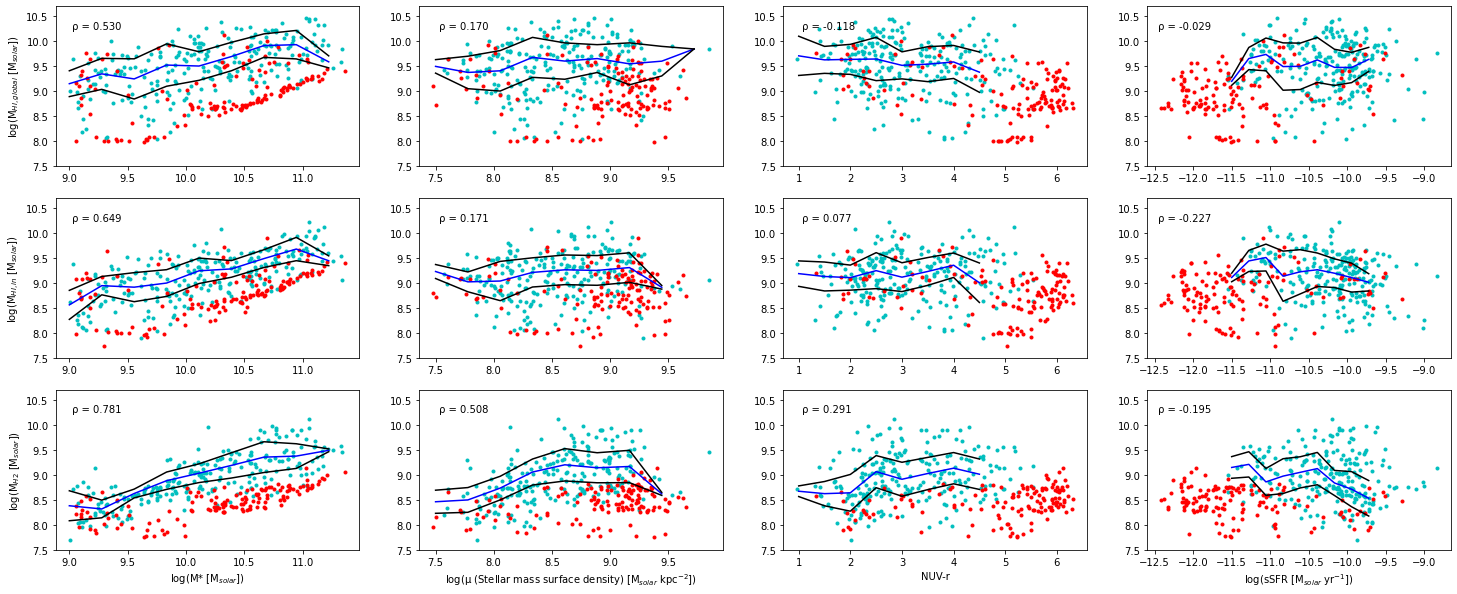

In [15]:
plt.figure(figsize=(25,10))
# Plotting the depletion times for the HI(global) mass against stellar properties
# MHI(global) against stellar mass
plt.subplot(3,4,1)
plt.plot(lgMSTAR_det, lgMHI_gl_det, 'c.')
plt.plot(lgMSTAR_ndet, lgMHI_gl_ndet, 'r.')
plt.plot(HIglbins_Mstar[:-1], MHIgl_Mstar[:-1], 'b-')
plt.plot(HIglbins_Mstar[:-1], HIglpMAD_Mstar[:-1], 'k-')
plt.plot(HIglbins_Mstar[:-1], HIglnMAD_Mstar[:-1], 'k-')
plt.text(9, 10.25, ' ρ = %.3f' % R_HIgl_Mstar[0])
plt.ylabel('log(M$_{HI, global}$ [M$_{solar}$])')
plt.ylim(7.5, 10.7)
# MHI(global) against stellar surface density
plt.subplot(3,4,2)
plt.plot(lgMuST_det, lgMHI_gl_det, 'c.')
plt.plot(lgMuST_ndet, lgMHI_gl_ndet, 'r.')
plt.plot(HIglbins_Must[:-1], MHIgl_Must[:-1], 'b-')
plt.plot(HIglbins_Must[:-1], HIglpMAD_Must[:-1], 'k-')
plt.plot(HIglbins_Must[:-1], HIglnMAD_Must[:-1], 'k-')
plt.text(7.5, 10.25, ' ρ = %.3f' % R_HIgl_MuST[0])
plt.ylim(7.5, 10.7)
# MHI(global) against NUV-r
plt.subplot(3,4,3)
plt.plot(NUVr_det, lgMHI_gl_det, 'c.')
plt.plot(NUVr_ndet, lgMHI_gl_ndet, 'r.')
plt.plot(HIglbins_NUVr[:-2], MHIgl_NUVr[:-2], 'b-')
plt.plot(HIglbins_NUVr[:-2], HIglpMAD_NUVr[:-2], 'k-')
plt.plot(HIglbins_NUVr[:-2], HIglnMAD_NUVr[:-2], 'k-')
plt.text(1, 10.25, ' ρ = %.3f' % R_HIgl_NUVr[0])
plt.ylim(7.5, 10.7)
# MHI(global) against sSFR
plt.subplot(3,4,4)
plt.plot(lgsSFR_det, lgMHI_gl_det, 'c.')
plt.plot(lgsSFR_ndet, lgMHI_gl_ndet, 'r.')
plt.plot(HIglbins_sSFR[:-1], MHIgl_sSFR[:-1], 'b-')
plt.plot(HIglbins_sSFR[:-1], HIglpMAD_sSFR[:-1], 'k-')
plt.plot(HIglbins_sSFR[:-1], HIglnMAD_sSFR[:-1], 'k-')
plt.text(-12.5, 10.25, ' ρ = %.3f' % R_HIgl_sSFR[0])
plt.ylim(7.5, 10.7)

# Plotting the depletion times for the HI(in) mass against stellar properties
# HI(in) against stellar mass
plt.subplot(3,4,5)
plt.plot(lgMSTAR_det, lgMHI_in_det, 'c.')
plt.plot(lgMSTAR_ndet, lgMHI_in_ndet, 'r.')
plt.plot(HIinbins_Mstar[:-1], MHIin_Mstar[:-1], 'b-')
plt.plot(HIinbins_Mstar[:-1], HIinpMAD_Mstar[:-1], 'k-')
plt.plot(HIinbins_Mstar[:-1], HIinnMAD_Mstar[:-1], 'k-')
plt.ylabel('log(M$_{HI, in}$ [M$_{solar}$])')
plt.text(9, 10.25, ' ρ = %.3f' % R_HIin_Mstar[0])
plt.ylim(7.5, 10.7)
# HI(in) against stellar surface density
plt.subplot(3,4,6)
plt.plot(lgMuST_det, lgMHI_in_det, 'c.')
plt.plot(lgMuST_ndet, lgMHI_in_ndet, 'r.')
plt.plot(HIinbins_Must[:-2], MHIin_Must[:-2], 'b-')
plt.plot(HIinbins_Must[:-2], HIinpMAD_Must[:-2], 'k-')
plt.plot(HIinbins_Must[:-2], HIinnMAD_Must[:-2], 'k-')
plt.text(7.5, 10.25, ' ρ = %.3f' % R_HIin_MuST[0])
plt.ylim(7.5, 10.7)
# HI(in) against NUV-r
plt.subplot(3,4,7)
plt.plot(NUVr_det, lgMHI_in_det, 'c.')
plt.plot(NUVr_ndet, lgMHI_in_ndet, 'r.')
plt.plot(HIinbins_NUVr[:-2], MHIin_NUVr[:-2], 'b-')
plt.plot(HIinbins_NUVr[:-2], HIinpMAD_NUVr[:-2], 'k-')
plt.plot(HIinbins_NUVr[:-2], HIinnMAD_NUVr[:-2], 'k-')
plt.text(1, 10.25, ' ρ = %.3f' % R_HIin_NUVr[0])
plt.ylim(7.5, 10.7)
# HI(in) against sSFR
plt.subplot(3,4,8)
plt.plot(lgsSFR_det, lgMHI_in_det, 'c.')
plt.plot(lgsSFR_ndet, lgMHI_in_ndet, 'r.')
plt.plot(HIinbins_sSFR[:-1], MHIin_sSFR[:-1], 'b-')
plt.plot(HIinbins_sSFR[:-1], HIinpMAD_sSFR[:-1], 'k-')
plt.plot(HIinbins_sSFR[:-1], HIinnMAD_sSFR[:-1], 'k-')
plt.text(-12.5, 10.25, ' ρ = %.3f' % R_HIin_sSFR[0])
plt.ylim(7.5, 10.7)

# Plotting the depletion times for the H2 mass against stellar properties
# H2 against stellar mass
plt.subplot(3,4,9)
plt.plot(lgMSTAR_det, lgMH2_det, 'c.')
plt.plot(lgMSTAR_ndet, limlgMH2_ndet, 'r.')
plt.plot(H2bins_Mstar[:-1], MH2_Mstar[:-1], 'b-')
plt.plot(H2bins_Mstar[:-1], H2pMAD_Mstar[:-1], 'k-')
plt.plot(H2bins_Mstar[:-1], H2nMAD_Mstar[:-1], 'k-')
plt.ylabel('log(M$_{H2}$ [M$_{solar}$])')
plt.xlabel('log(M* [M$_{solar}$])')
plt.text(9, 10.25, ' ρ = %.3f' % R_H2_Mstar[0])
plt.ylim(7.5, 10.7)
# H2 against stellar surface density
plt.subplot(3,4,10)
plt.plot(lgMuST_det, lgMH2_det, 'c.')
plt.plot(lgMuST_ndet, limlgMH2_ndet, 'r.')
plt.plot(H2bins_Must[:-2], MH2_Must[:-2], 'b-')
plt.plot(H2bins_Must[:-2], H2pMAD_Must[:-2], 'k-')
plt.plot(H2bins_Must[:-2], H2nMAD_Must[:-2], 'k-')
plt.xlabel('log(μ (Stellar mass surface density) [M$_{solar}$ kpc$^{-2}$])')
plt.text(7.5, 10.25, ' ρ = %.3f' % R_H2_MuST[0])
plt.ylim(7.5, 10.7)
# H2 against NUVr
plt.subplot(3,4,11)
plt.plot(NUVr_det, lgMH2_det, 'c.')
plt.plot(NUVr_ndet, limlgMH2_ndet, 'r.')
plt.plot(H2bins_NUVr[:-2], MH2_NUVr[:-2], 'b-')
plt.plot(H2bins_NUVr[:-2], H2pMAD_NUVr[:-2], 'k-')
plt.plot(H2bins_NUVr[:-2], H2nMAD_NUVr[:-2], 'k-')
plt.xlabel('NUV-r')
plt.text(1, 10.25, ' ρ = %.3f' % R_H2_NUVr[0])
plt.ylim(7.5, 10.7)
# H2 against sSFR
plt.subplot(3,4,12)
plt.plot(lgsSFR_det, lgMH2_det, 'c.')
plt.plot(lgsSFR_ndet, limlgMH2_ndet, 'r.')
plt.plot(H2bins_sSFR[:-1], MH2_sSFR[:-1], 'b-')
plt.plot(H2bins_sSFR[:-1], H2pMAD_sSFR[:-1], 'k-')
plt.plot(H2bins_sSFR[:-1], H2nMAD_sSFR[:-1], 'k-')
plt.xlabel('log(sSFR [M$_{solar}$ yr$^{-1}$])')
plt.text(-12.5, 10.25, ' ρ = %.3f' % R_H2_sSFR[0])
plt.ylim(7.5, 10.7);

In [31]:
# Finding the scatter (difference) between the median lines and the median absolute deviation
print(np.mean(H2MAD_Mstar))

[8.38553715 8.32125854 8.63075638 8.88724709 9.03702927 9.19333839
 9.35861492 9.37962341 9.49492359 0.        ]
[8.68551636 8.49803448 8.71867371 9.06049442 9.22446966 9.4462862
 9.66657925 9.62652874 9.52271652 0.        ]
[8.08555794 8.14448261 8.54283905 8.71399975 8.84958887 8.94039059
 9.0506506  9.13271809 9.46713066 0.        ]
[0.29997921 0.17677593 0.08791733 0.17324734 0.1874404  0.25294781
 0.30796432 0.24690533 0.02779293 0.        ]
0.17609705924987792


4) Investigating how the trends are affected by the binning the bulge-to-total ratio- plotting trends for the spiral dominated galaxies and then for the total of the sample

In [17]:
# Finding the distribution of galaxies in the bulge-to-total sample
print('B/T > 0.6:', len(np.where(B2TM > 0.6)[0]))
print('B/T > 0.4:', len(np.where(B2TM > 0.4)[0]))
print('B/T > 0.2:', len(np.where(B2TM > 0.2)[0]))
print('B/T > 0.1:', len(np.where(B2TM > 0.1)[0]))

B/T > 0.6: 16
B/T > 0.4: 64
B/T > 0.2: 168
B/T > 0.1: 224


In [18]:
# Due to the large number of galaxies dominated by a disk component need to change the bins to focus more of those galaxies
# Over half the galaxies present in the sample are between 0 and 0.2 on the bulge-to-total ratio
lgMH2_tot = lgMH2 + limlgMH2
B2TM1 = B2TM[np.where(B2TM < 0.2)]
B2TM2 = B2TM[np.where((B2TM > 0.2) & (B2TM < 0.4))]
B2TM3 = B2TM[np.where(B2TM > 0.4)]

lgMHI_in1 = lgMHI_in[np.where(B2TM < 0.2)]
lgMHI_in2 = lgMHI_in[np.where((B2TM > 0.2) & (B2TM < 0.4))]
lgMHI_in3 = lgMHI_in[np.where(B2TM > 0.4)]

lgMHI_gl1 = lgMHI_gl[np.where(B2TM < 0.2)]
lgMHI_gl2 = lgMHI_gl[np.where((B2TM > 0.2) & (B2TM < 0.4))]
lgMHI_gl3 = lgMHI_gl[np.where(B2TM > 0.4)]

lgMH2_tot1 = lgMH2_tot[np.where(B2TM < 0.2)]
lgMH2_tot2 = lgMH2_tot[np.where((B2TM > 0.2) & (B2TM < 0.4))]
lgMH2_tot3 = lgMH2_tot[np.where(B2TM > 0.4)]

lgMSTAR1 = lgMSTAR[np.where(B2TM < 0.2)]
lgMSTAR2 = lgMSTAR[np.where((B2TM > 0.2) & (B2TM < 0.4))]
lgMSTAR3 = lgMSTAR[np.where(B2TM > 0.4)]

NUVr1 = NUVr[np.where(B2TM < 0.2)]
NUVr2 = NUVr[np.where((B2TM > 0.2) & (B2TM < 0.4))]
NUVr3 = NUVr[np.where(B2TM > 0.4)]

lgsSFR1 = lgsSFR[np.where(B2TM < 0.2)]
lgsSFR2 = lgsSFR[np.where((B2TM > 0.2) & (B2TM < 0.4))]
lgsSFR3 = lgsSFR[np.where(B2TM > 0.4)]

lgMuST1 = lgMuST[np.where(B2TM < 0.2)]
lgMuST2 = lgMuST[np.where((B2TM > 0.2) & (B2TM < 0.4))]
lgMuST3 = lgMuST[np.where(B2TM > 0.4)]

HIsrc1 = HIsrc[np.where(B2TM < 0.2)]
HIsrc2 = HIsrc[np.where((B2TM > 0.2) & (B2TM < 0.4))]
HIsrc3 = HIsrc[np.where(B2TM > 0.4)]

FLAG_CO1 = FLAG_CO[np.where(B2TM < 0.2)]
FLAG_CO2 = FLAG_CO[np.where((B2TM > 0.2) & (B2TM < 0.4))]
FLAG_CO3 = FLAG_CO[np.where(B2TM > 0.4)]

In [19]:
# Finding which galaxies in each bin are detections vs non-detection
lgMHI_in1_det = lgMHI_in1[np.where(HIsrc1 < 4)]
lgMHI_in1_ndet = lgMHI_in1[np.where(HIsrc1 >= 4)]
lgMHI_in2_det = lgMHI_in2[np.where(HIsrc2 < 4)]
lgMHI_in2_ndet = lgMHI_in2[np.where(HIsrc2 >= 4)]
lgMHI_in3_det = lgMHI_in3[np.where(HIsrc3 < 4)]
lgMHI_in3_ndet = lgMHI_in3[np.where(HIsrc3 >= 4)]

lgMHI_gl1_det = lgMHI_gl1[np.where(HIsrc1 < 4)]
lgMHI_gl1_ndet = lgMHI_gl1[np.where(HIsrc1 >= 4)]
lgMHI_gl2_det = lgMHI_gl2[np.where(HIsrc2 < 4)]
lgMHI_gl2_ndet = lgMHI_gl2[np.where(HIsrc2 >= 4)]
lgMHI_gl3_det = lgMHI_gl3[np.where(HIsrc3 < 4)]
lgMHI_gl3_ndet = lgMHI_gl3[np.where(HIsrc3 >= 4)]

lgMH2_tot1_det = lgMH2_tot1[np.where(FLAG_CO1 < 2)]
lgMH2_tot1_ndet = lgMH2_tot1[np.where(FLAG_CO1 > 1)]
lgMH2_tot2_det = lgMH2_tot2[np.where(FLAG_CO2 < 2)]
lgMH2_tot2_ndet = lgMH2_tot2[np.where(FLAG_CO2 > 1)]
lgMH2_tot3_det = lgMH2_tot3[np.where(FLAG_CO3 < 2)]
lgMH2_tot3_ndet = lgMH2_tot3[np.where(FLAG_CO3 > 1)]

In [20]:
# Adjusting the x-axis (stellar properties arrays) so that the detections and non-detections are of the same length
lgMSTAR1_det = lgMSTAR1[np.where(HIsrc1 < 4)]
lgMSTAR1_ndet = lgMSTAR1[np.where(HIsrc1 >= 4)]
lgMSTAR2_det = lgMSTAR2[np.where(HIsrc2 < 4)]
lgMSTAR2_ndet = lgMSTAR2[np.where(HIsrc2 >= 4)]
lgMSTAR3_det = lgMSTAR3[np.where(HIsrc3 < 4)]
lgMSTAR3_ndet = lgMSTAR3[np.where(HIsrc3 >= 4)]

NUVr1_det = NUVr1[np.where(HIsrc1 < 4)]
NUVr1_ndet = NUVr1[np.where(HIsrc1 >= 4)]
NUVr2_det = NUVr2[np.where(HIsrc2 < 4)]
NUVr2_ndet = NUVr2[np.where(HIsrc2 >= 4)]
NUVr3_det = NUVr3[np.where(HIsrc3 < 4)]
NUVr3_ndet = NUVr3[np.where(HIsrc3 >= 4)]

lgsSFR1_det = lgsSFR1[np.where(HIsrc1 < 4)]
lgsSFR1_ndet = lgsSFR1[np.where(HIsrc1 >= 4)]
lgsSFR2_det = lgsSFR2[np.where(HIsrc2 < 4)]
lgsSFR2_ndet = lgsSFR2[np.where(HIsrc2 >= 4)]
lgsSFR3_det = lgsSFR3[np.where(HIsrc3 < 4)]
lgsSFR3_ndet = lgsSFR3[np.where(HIsrc3 >= 4)]

lgMuST1_det = lgMuST1[np.where(HIsrc1 < 4)]
lgMuST1_ndet = lgMuST1[np.where(HIsrc1 >= 4)]
lgMuST2_det = lgMuST2[np.where(HIsrc2 < 4)]
lgMuST2_ndet = lgMuST2[np.where(HIsrc2 >= 4)]
lgMuST3_det = lgMuST3[np.where(HIsrc3 < 4)]
lgMuST3_ndet = lgMuST3[np.where(HIsrc3 >= 4)]

In [21]:
# x-axis values for the H2 where the detections and non-detections of CO are different to those of HI
lgMSTAR1_detH2 = lgMSTAR1[np.where(FLAG_CO1 < 2)]
lgMSTAR1_ndetH2 = lgMSTAR1[np.where(FLAG_CO1 > 1)]
lgMSTAR2_detH2 = lgMSTAR2[np.where(FLAG_CO2 < 2)]
lgMSTAR2_ndetH2 = lgMSTAR2[np.where(FLAG_CO2 > 1)]
lgMSTAR3_detH2 = lgMSTAR3[np.where(FLAG_CO3 < 2)]
lgMSTAR3_ndetH2 = lgMSTAR3[np.where(FLAG_CO3 > 1)]

NUVr1_detH2 = NUVr1[np.where(FLAG_CO1 < 2)]
NUVr1_ndetH2 = NUVr1[np.where(FLAG_CO1 > 1)]
NUVr2_detH2 = NUVr2[np.where(FLAG_CO2 < 2)]
NUVr2_ndetH2 = NUVr2[np.where(FLAG_CO2 > 1)]
NUVr3_detH2 = NUVr3[np.where(FLAG_CO3 < 2)]
NUVr3_ndetH2 = NUVr3[np.where(FLAG_CO3 > 1)]

lgsSFR1_detH2 = lgsSFR1[np.where(FLAG_CO1 < 2)]
lgsSFR1_ndetH2 = lgsSFR1[np.where(FLAG_CO1 > 1)]
lgsSFR2_detH2 = lgsSFR2[np.where(FLAG_CO2 < 2)]
lgsSFR2_ndetH2 = lgsSFR2[np.where(FLAG_CO2 > 1)]
lgsSFR3_detH2 = lgsSFR3[np.where(FLAG_CO3 < 2)]
lgsSFR3_ndetH2 = lgsSFR3[np.where(FLAG_CO3 > 1)]

lgMuST1_detH2 = lgMuST1[np.where(FLAG_CO1 < 2)]
lgMuST1_ndetH2 = lgMuST1[np.where(FLAG_CO1 > 1)]
lgMuST2_detH2 = lgMuST2[np.where(FLAG_CO2 < 2)]
lgMuST2_ndetH2 = lgMuST2[np.where(FLAG_CO2 > 1)]
lgMuST3_detH2 = lgMuST3[np.where(FLAG_CO3 < 2)]
lgMuST3_ndetH2 = lgMuST3[np.where(FLAG_CO3 > 1)]

In [22]:
# Finding the running median of the galaxies in the sample for the HI global (B2TM < 0.2)
# Arrays for the bins
bins_Mstar = np.linspace(9, 11.5, 10)
bins_NUVr = np.linspace(1, 7, 10)
bins_sSFR = np.linspace(-11.5, -9.0, 10)
bins_Must = np.linspace(7.5, 10, 10)

In [23]:
# Finding the running median of the galaxies in the sample for the HI (global)
# Array of zeroes to store the median of each bin
HIglmedian_Mstar = np.zeros(len(bins_Mstar)) 
HIglmedian_Mstar1 = np.zeros(len(bins_Mstar)) # <--- if the variable has 1 at the end it is for B2TM < 0.2

HIglmedian_NUVr = np.zeros(len(bins_NUVr))
HIglmedian_NUVr1 = np.zeros(len(bins_NUVr))

HIglmedian_sSFR = np.zeros(len(bins_sSFR))
HIglmedian_sSFR1 = np.zeros(len(bins_sSFR))

HIglmedian_Must = np.zeros(len(bins_Must))
HIglmedian_Must1 = np.zeros(len(bins_Must))

In [24]:
# Using a for loop to iterate over the median values for each of the bins
for i in range(len(bins_Mstar) -1):
  # Medians for the Mstar graph
  HIglmedian_Mstar[i] = np.median(lgMHI_gl[np.where((lgMSTAR[np.where(lgMHI_gl)] >= bins_Mstar[i]) & (lgMSTAR[np.where(lgMHI_gl)] <= bins_Mstar[i+1]))])
  HIglmedian_Mstar1[i] = np.median(lgMHI_gl1[np.where((lgMSTAR1[np.where(lgMHI_gl1)] >= bins_Mstar[i]) & (lgMSTAR1[np.where(lgMHI_gl1)] <= bins_Mstar[i+1]))])

  # Medians for the NUVr graph
  HIglmedian_NUVr[i] = np.median(lgMHI_gl[np.where((NUVr[np.where(lgMHI_gl)] >= bins_NUVr[i]) & (NUVr[np.where(lgMHI_gl)] <= bins_NUVr[i+1]))])
  HIglmedian_NUVr1[i] = np.median(lgMHI_gl1[np.where((NUVr1[np.where(lgMHI_gl1)] >= bins_NUVr[i]) & (NUVr1[np.where(lgMHI_gl1)] <= bins_NUVr[i+1]))])

  # Medians for the sSFR graph
  HIglmedian_sSFR[i] = np.median(lgMHI_gl[np.where((lgsSFR[np.where(lgMHI_gl)] >= bins_sSFR[i]) & (lgsSFR[np.where(lgMHI_gl)] <= bins_sSFR[i+1]))])
  HIglmedian_sSFR1[i] = np.median(lgMHI_gl1[np.where((lgsSFR1[np.where(lgMHI_gl1)] >= bins_sSFR[i]) & (lgsSFR1[np.where(lgMHI_gl1)] <= bins_sSFR[i+1]))])
  
  # Medians for the Mu star graph
  HIglmedian_Must[i] = np.median(lgMHI_gl[np.where((lgMuST[np.where(lgMHI_gl)] >= bins_Must[i]) & (lgMuST[np.where(lgMHI_gl)] <= bins_Must[i+1]))])
  HIglmedian_Must1[i] = np.median(lgMHI_gl1[np.where((lgMuST1[np.where(lgMHI_gl1)] >= bins_Must[i]) & (lgMuST1[np.where(lgMHI_gl1)] <= bins_Must[i+1]))]) 

/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [25]:
# Finding the running median of the galaxies in the sample for the HI (inner)
# Array of zeroes to store the median of each bin
HIinmedian_Mstar = np.zeros(len(bins_Mstar)) 
HIinmedian_Mstar1 = np.zeros(len(bins_Mstar)) # <--- if the variable has 1 at the end it is for B2TM < 0.2

HIinmedian_NUVr = np.zeros(len(bins_NUVr))
HIinmedian_NUVr1 = np.zeros(len(bins_NUVr))

HIinmedian_sSFR = np.zeros(len(bins_sSFR))
HIinmedian_sSFR1 = np.zeros(len(bins_sSFR))

HIinmedian_Must = np.zeros(len(bins_Must))
HIinmedian_Must1 = np.zeros(len(bins_Must))

In [26]:
# Using a for loop to iterate over the median values for each of the bins
for i in range(len(bins_Mstar) -1):
  # Medians for the Mstar graph
  HIinmedian_Mstar[i] = np.median(lgMHI_in[np.where((lgMSTAR[np.where(lgMHI_in)] >= bins_Mstar[i]) & (lgMSTAR[np.where(lgMHI_in)] <= bins_Mstar[i+1]))])
  HIinmedian_Mstar1[i] = np.median(lgMHI_in1[np.where((lgMSTAR1[np.where(lgMHI_in1)] >= bins_Mstar[i]) & (lgMSTAR1[np.where(lgMHI_in1)] <= bins_Mstar[i+1]))])

  # Medians for the NUVr graph
  HIinmedian_NUVr[i] = np.median(lgMHI_in[np.where((NUVr[np.where(lgMHI_in)] >= bins_NUVr[i]) & (NUVr[np.where(lgMHI_in)] <= bins_NUVr[i+1]))])
  HIinmedian_NUVr1[i] = np.median(lgMHI_in1[np.where((NUVr1[np.where(lgMHI_in1)] >= bins_NUVr[i]) & (NUVr1[np.where(lgMHI_in1)] <= bins_NUVr[i+1]))])

  # Medians for the sSFR graph
  HIinmedian_sSFR[i] = np.median(lgMHI_in[np.where((lgsSFR[np.where(lgMHI_in)] >= bins_sSFR[i]) & (lgsSFR[np.where(lgMHI_in)] <= bins_sSFR[i+1]))])
  HIinmedian_sSFR1[i] = np.median(lgMHI_in1[np.where((lgsSFR1[np.where(lgMHI_in1)] >= bins_sSFR[i]) & (lgsSFR1[np.where(lgMHI_in1)] <= bins_sSFR[i+1]))])
  
  # Medians for the Mu star graph
  HIinmedian_Must[i] = np.median(lgMHI_in[np.where((lgMuST[np.where(lgMHI_in)] >= bins_Must[i]) & (lgMuST[np.where(lgMHI_in)] <= bins_Must[i+1]))])
  HIinmedian_Must1[i] = np.median(lgMHI_in1[np.where((lgMuST1[np.where(lgMHI_in1)] >= bins_Must[i]) & (lgMuST1[np.where(lgMHI_in1)] <= bins_Must[i+1]))]) 

/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [27]:
# Finding the running median of the galaxies in the sample for the H2
# Array of zeroes to store the median of each bin
H2median_Mstar = np.zeros(len(bins_Mstar)) 
H2median_Mstar1 = np.zeros(len(bins_Mstar)) # <--- if the variable has 1 at the end it is for B2TM < 0.2

H2median_NUVr = np.zeros(len(bins_NUVr))
H2median_NUVr1 = np.zeros(len(bins_NUVr))

H2median_sSFR = np.zeros(len(bins_sSFR))
H2median_sSFR1 = np.zeros(len(bins_sSFR))

H2median_Must = np.zeros(len(bins_Must))
H2median_Must1 = np.zeros(len(bins_Must))

In [28]:
# Using a for loop to iterate over the median values for each of the bins
for i in range(len(bins_Mstar) -1):
  # Medians for the Mstar graph
  H2median_Mstar[i] = np.median(lgMH2_tot[np.where((lgMSTAR[np.where(lgMH2_tot)] >= bins_Mstar[i]) & (lgMSTAR[np.where(lgMH2_tot)] <= bins_Mstar[i+1]))])
  H2median_Mstar1[i] = np.median(lgMH2_tot1[np.where((lgMSTAR1[np.where(lgMH2_tot1)] >= bins_Mstar[i]) & (lgMSTAR1[np.where(lgMH2_tot1)] <= bins_Mstar[i+1]))])

  # Medians for the NUVr graph
  H2median_NUVr[i] = np.median(lgMH2_tot[np.where((NUVr[np.where(lgMH2_tot)] >= bins_NUVr[i]) & (NUVr[np.where(lgMH2_tot)] <= bins_NUVr[i+1]))])
  H2median_NUVr1[i] = np.median(lgMH2_tot1[np.where((NUVr1[np.where(lgMH2_tot1)] >= bins_NUVr[i]) & (NUVr1[np.where(lgMH2_tot1)] <= bins_NUVr[i+1]))])

  # Medians for the sSFR graph
  H2median_sSFR[i] = np.median(lgMH2_tot[np.where((lgsSFR[np.where(lgMH2_tot)] >= bins_sSFR[i]) & (lgsSFR[np.where(lgMH2_tot)] <= bins_sSFR[i+1]))])
  H2median_sSFR1[i] = np.median(lgMH2_tot1[np.where((lgsSFR1[np.where(lgMH2_tot1)] >= bins_sSFR[i]) & (lgsSFR1[np.where(lgMH2_tot1)] <= bins_sSFR[i+1]))])

  # Medians for the Mu star graph
  H2median_Must[i] = np.median(lgMH2_tot[np.where((lgMuST[np.where(lgMH2_tot)] >= bins_Must[i]) & (lgMuST[np.where(lgMH2_tot)] <= bins_Must[i+1]))])
  H2median_Must1[i] = np.median(lgMH2_tot1[np.where((lgMuST1[np.where(lgMH2_tot1)] >= bins_Must[i]) & (lgMuST1[np.where(lgMH2_tot1)] <= bins_Must[i+1]))]) 

/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in true_divide
  ret = ret.dtype.type(ret / rcount)


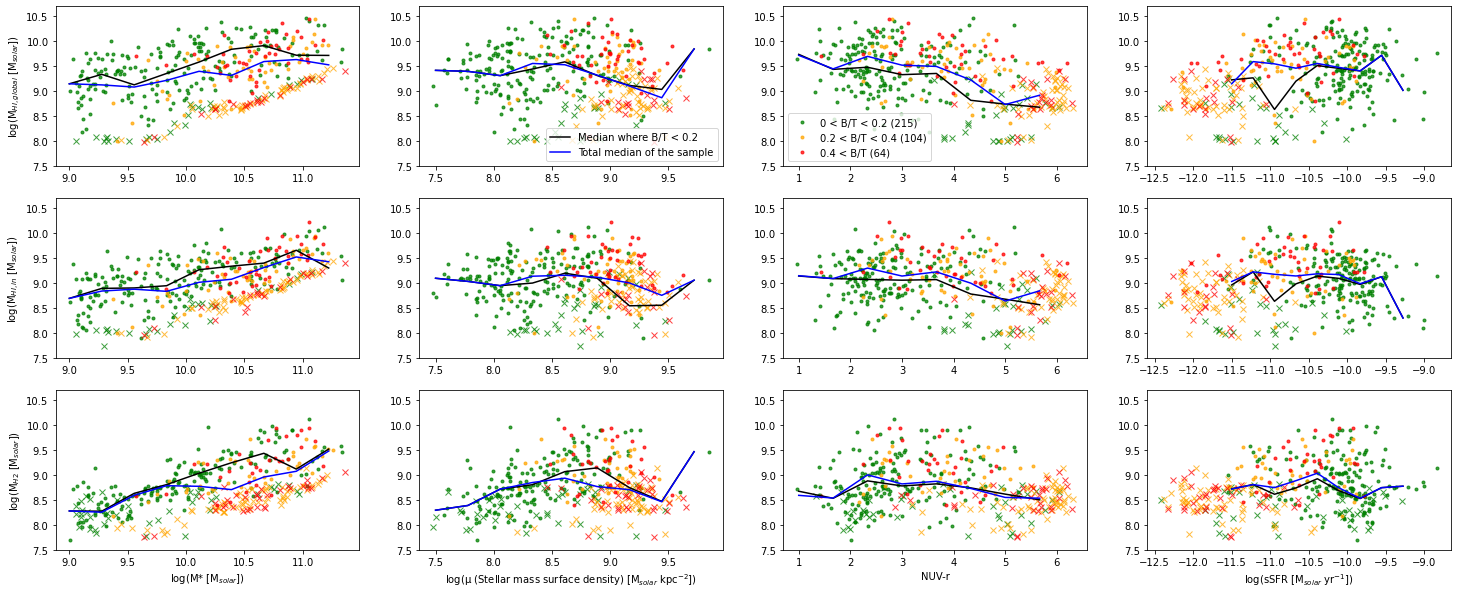

In [29]:
plt.figure(figsize=(25,10))
# Plotting the HI(global) mass against stellar properties
# MHI(global) against stellar mass
plt.subplot(3,4,1)
plt.plot(lgMSTAR1_det, lgMHI_gl1_det, 'green', alpha = 0.75, marker='.', linestyle='none')
plt.plot(lgMSTAR1_ndet, lgMHI_gl1_ndet, 'green', alpha = 0.75, marker='x', linestyle='none')
plt.plot(lgMSTAR2_det, lgMHI_gl2_det, 'orange', alpha = 0.75, marker='.', linestyle='none')
plt.plot(lgMSTAR2_ndet, lgMHI_gl2_ndet, 'orange', alpha = 0.75, marker='x', linestyle='none')
plt.plot(lgMSTAR3_det, lgMHI_gl3_det, 'red', alpha = 0.75, marker='.', linestyle='none')
plt.plot(lgMSTAR3_ndet, lgMHI_gl3_ndet, 'red', alpha = 0.75, marker='x', linestyle='none')
plt.plot(bins_Mstar[:-1], HIglmedian_Mstar1[:-1], 'k-')
plt.plot(bins_Mstar[:-1], HIglmedian_Mstar[:-1], 'b-')
plt.ylabel('log(M$_{HI, global}$ [M$_{solar}$])')
plt.ylim(7.5, 10.7)
# MHI(global) against stellar surface density
plt.subplot(3,4,2)
plt.plot(lgMuST1_det, lgMHI_gl1_det, 'green', alpha = 0.75, marker = '.', linestyle='none')
plt.plot(lgMuST1_ndet, lgMHI_gl1_ndet, 'green', alpha = 0.75, marker = 'x', linestyle='none')
plt.plot(lgMuST2_det, lgMHI_gl2_det, 'orange', alpha = 0.75, marker= '.', linestyle='none')
plt.plot(lgMuST2_ndet, lgMHI_gl2_ndet, 'orange', alpha = 0.75, marker= 'x', linestyle='none')
plt.plot(lgMuST3_det, lgMHI_gl3_det, 'red', alpha = 0.75, marker= '.', linestyle='none')
plt.plot(lgMuST3_ndet, lgMHI_gl3_ndet, 'red', alpha = 0.75, marker= 'x', linestyle='none')
plt.plot(bins_Must[:-1], HIglmedian_Must1[:-1], 'k-', label='Median where B/T < 0.2')
plt.plot(bins_Must[:-1], HIglmedian_Must[:-1], 'b-', label='Total median of the sample')
plt.legend(loc='lower right')
plt.ylim(7.5, 10.7)
# MHI(global) against NUV-r
plt.subplot(3,4,3)
plt.plot(NUVr1_det, lgMHI_gl1_det,'green', alpha = 0.75, marker= '.', linestyle='none', label='0 < B/T < 0.2 (215)')
plt.plot(NUVr1_ndet, lgMHI_gl1_ndet,'green', alpha = 0.75, marker= 'x', linestyle='none')
plt.plot(NUVr2_det, lgMHI_gl2_det, 'orange', alpha = 0.75, marker= '.', linestyle='none', label='0.2 < B/T < 0.4 (104)')
plt.plot(NUVr2_ndet, lgMHI_gl2_ndet, 'orange', alpha = 0.75, marker= 'x', linestyle='none')
plt.plot(NUVr3_det, lgMHI_gl3_det, 'red', alpha = 0.75, marker= '.', linestyle='none', label='0.4 < B/T (64)')
plt.plot(NUVr3_ndet, lgMHI_gl3_ndet, 'red', alpha = 0.75, marker= 'x', linestyle='none')
plt.plot(bins_NUVr[:-1], HIglmedian_NUVr1[:-1], 'k-')
plt.plot(bins_NUVr[:-1], HIglmedian_NUVr[:-1], 'b-')
plt.legend(loc='lower left')
plt.ylim(7.5, 10.7)
# MHI(global) against sSFR
plt.subplot(3,4,4)
plt.plot(lgsSFR1_det, lgMHI_gl1_det, 'green', alpha = 0.75, marker= '.', linestyle='none')
plt.plot(lgsSFR1_ndet, lgMHI_gl1_ndet, 'green', alpha = 0.75, marker= 'x', linestyle='none')
plt.plot(lgsSFR2_det, lgMHI_gl2_det, 'orange', alpha = 0.75, marker= '.', linestyle='none')
plt.plot(lgsSFR2_ndet, lgMHI_gl2_ndet, 'orange', alpha = 0.75, marker= 'x', linestyle='none')
plt.plot(lgsSFR3_det, lgMHI_gl3_det, 'red', alpha = 0.75, marker= '.', linestyle='none')
plt.plot(lgsSFR3_ndet, lgMHI_gl3_ndet, 'red', alpha = 0.75, marker= 'x', linestyle='none')
plt.plot(bins_sSFR[:-1], HIglmedian_sSFR1[:-1], 'k-')
plt.plot(bins_sSFR[:-1], HIglmedian_sSFR[:-1], 'b-')
plt.ylim(7.5, 10.7)

# Plotting the HI(in) mass against stellar properties
# HI(in) against stellar mass
plt.subplot(3,4,5)
plt.plot(lgMSTAR1_det, lgMHI_in1_det, 'green', alpha = 0.75, marker= '.', linestyle='none')
plt.plot(lgMSTAR1_ndet, lgMHI_in1_ndet, 'green', alpha = 0.75, marker= 'x', linestyle='none')
plt.plot(lgMSTAR2_det, lgMHI_in2_det, 'orange', alpha = 0.75, marker= '.', linestyle='none')
plt.plot(lgMSTAR2_ndet, lgMHI_in2_ndet, 'orange', alpha = 0.75, marker= 'x', linestyle='none')
plt.plot(lgMSTAR3_det, lgMHI_in3_det, 'red', alpha = 0.75, marker= '.', linestyle='none')
plt.plot(lgMSTAR3_ndet, lgMHI_in3_ndet, 'red', alpha = 0.75, marker= 'x', linestyle='none')
plt.plot(bins_Mstar[:-1], HIinmedian_Mstar1[:-1], 'k-')
plt.plot(bins_Mstar[:-1], HIinmedian_Mstar[:-1], 'b-')
plt.ylabel('log(M$_{HI, in}$ [M$_{solar}$])')
plt.ylim(7.5, 10.7)
# HI(in) against stellar surface density
plt.subplot(3,4,6)
plt.plot(lgMuST1_det, lgMHI_in1_det, 'green', alpha = 0.75, marker= '.', linestyle='none')
plt.plot(lgMuST1_ndet, lgMHI_in1_ndet, 'green', alpha = 0.75, marker= 'x', linestyle='none')
plt.plot(lgMuST2_det, lgMHI_in2_det, 'orange', alpha = 0.75, marker= '.', linestyle='none')
plt.plot(lgMuST2_ndet, lgMHI_in2_ndet, 'orange', alpha = 0.75, marker= 'x', linestyle='none')
plt.plot(lgMuST3_det, lgMHI_in3_det, 'red', alpha = 0.75, marker= '.', linestyle='none')
plt.plot(lgMuST3_ndet, lgMHI_in3_ndet, 'red', alpha = 0.75, marker= 'x', linestyle='none')
plt.plot(bins_Must[:-1], HIinmedian_Must1[:-1], 'k-')
plt.plot(bins_Must[:-1], HIinmedian_Must[:-1], 'b-')
plt.ylim(7.5, 10.7)
# HI(in) against NUV-r
plt.subplot(3,4,7)
plt.plot(NUVr1_det, lgMHI_in1_det, 'green', alpha = 0.75, marker= '.', linestyle='none')
plt.plot(NUVr1_ndet, lgMHI_in1_ndet, 'green', alpha = 0.75, marker= 'x', linestyle='none')
plt.plot(NUVr2_det, lgMHI_in2_det, 'orange', alpha = 0.75, marker= '.', linestyle='none')
plt.plot(NUVr2_ndet, lgMHI_in2_ndet, 'orange', alpha = 0.75, marker= 'x', linestyle='none')
plt.plot(NUVr3_det, lgMHI_in3_det, 'red', alpha = 0.75, marker= '.', linestyle='none')
plt.plot(NUVr3_ndet, lgMHI_in3_ndet, 'red', alpha = 0.75, marker= 'x', linestyle='none')
plt.plot(bins_NUVr[:-1], HIinmedian_NUVr1[:-1], 'k-')
plt.plot(bins_NUVr[:-1], HIinmedian_NUVr[:-1], 'b-')
plt.ylim(7.5, 10.7)
# HI(in) against sSFR
plt.subplot(3,4,8)
plt.plot(lgsSFR1_det, lgMHI_in1_det, 'green', alpha = 0.75, marker= '.', linestyle='none')
plt.plot(lgsSFR1_ndet, lgMHI_in1_ndet, 'green', alpha = 0.75, marker= 'x', linestyle='none')
plt.plot(lgsSFR2_det, lgMHI_in2_det, 'orange', alpha = 0.75, marker= '.', linestyle='none')
plt.plot(lgsSFR2_ndet, lgMHI_in2_ndet, 'orange', alpha = 0.75, marker= 'x', linestyle='none')
plt.plot(lgsSFR3_det, lgMHI_in3_det, 'red', alpha = 0.75, marker= '.', linestyle='none')
plt.plot(lgsSFR3_ndet, lgMHI_in3_ndet, 'red', alpha = 0.75, marker= 'x', linestyle='none')
plt.plot(bins_sSFR[:-1], HIinmedian_sSFR1[:-1], 'k-')
plt.plot(bins_sSFR[:-1], HIinmedian_sSFR[:-1], 'b-')
plt.ylim(7.5, 10.7)

# Plotting the the H2 mass against stellar properties
# H2 against stellar mass
plt.subplot(3,4,9)
plt.plot(lgMSTAR1_detH2, lgMH2_tot1_det, 'green', alpha = 0.75, marker= '.', linestyle='none')
plt.plot(lgMSTAR1_ndetH2, lgMH2_tot1_ndet, 'green', alpha = 0.75, marker= 'x', linestyle='none')
plt.plot(lgMSTAR2_detH2, lgMH2_tot2_det, 'orange', alpha = 0.75, marker= '.', linestyle='none')
plt.plot(lgMSTAR2_ndetH2, lgMH2_tot2_ndet, 'orange', alpha = 0.75, marker= 'x', linestyle='none')
plt.plot(lgMSTAR3_detH2, lgMH2_tot3_det, 'red', alpha = 0.75, marker= '.', linestyle='none')
plt.plot(lgMSTAR3_ndetH2, lgMH2_tot3_ndet, 'red', alpha = 0.75, marker= 'x', linestyle='none')
plt.plot(bins_Mstar[:-1], H2median_Mstar1[:-1], 'k-')
plt.plot(bins_Mstar[:-1], H2median_Mstar[:-1], 'b-')
plt.ylabel('log(M$_{H2}$ [M$_{solar}$])')
plt.xlabel('log(M* [M$_{solar}$])')
plt.ylim(7.5, 10.7)
# H2 against stellar surface density
plt.subplot(3,4,10)
plt.plot(lgMuST1_detH2, lgMH2_tot1_det, 'green', alpha = 0.75, marker= '.', linestyle='none')
plt.plot(lgMuST1_ndetH2, lgMH2_tot1_ndet, 'green', alpha = 0.75, marker= 'x', linestyle='none')
plt.plot(lgMuST2_detH2, lgMH2_tot2_det, 'orange', alpha = 0.75, marker= '.', linestyle='none')
plt.plot(lgMuST2_ndetH2, lgMH2_tot2_ndet, 'orange', alpha = 0.75, marker= 'x', linestyle='none')
plt.plot(lgMuST3_detH2, lgMH2_tot3_det, 'red', alpha = 0.75, marker= '.', linestyle='none')
plt.plot(lgMuST3_ndetH2, lgMH2_tot3_ndet, 'red', alpha = 0.75, marker= 'x', linestyle='none')
plt.plot(bins_Must[:-1], H2median_Must1[:-1], 'k-')
plt.plot(bins_Must[:-1], H2median_Must[:-1], 'b-')
plt.xlabel('log(μ (Stellar mass surface density) [M$_{solar}$ kpc$^{-2}$])')
plt.ylim(7.5, 10.7)
# H2 against NUVr
plt.subplot(3,4,11)
plt.plot(NUVr1_detH2, lgMH2_tot1_det, 'green', alpha = 0.75, marker= '.', linestyle='none')
plt.plot(NUVr1_ndetH2, lgMH2_tot1_ndet, 'green', alpha = 0.75, marker= 'x', linestyle='none')
plt.plot(NUVr2_detH2, lgMH2_tot2_det, 'orange', alpha = 0.75, marker= '.', linestyle='none')
plt.plot(NUVr2_ndetH2, lgMH2_tot2_ndet, 'orange', alpha = 0.75, marker= 'x', linestyle='none')
plt.plot(NUVr3_detH2, lgMH2_tot3_det, 'red', alpha = 0.75, marker= '.', linestyle='none')
plt.plot(NUVr3_ndetH2, lgMH2_tot3_ndet, 'red', alpha = 0.75, marker= 'x', linestyle='none')
plt.plot(bins_NUVr[:-1], H2median_NUVr1[:-1], 'k-')
plt.plot(bins_NUVr[:-1], H2median_NUVr[:-1], 'b-')
plt.xlabel('NUV-r')
plt.ylim(7.5, 10.7)
# H2 against sSFR
plt.subplot(3,4,12)
plt.plot(lgsSFR1_detH2, lgMH2_tot1_det, 'green', alpha = 0.75, marker= '.', linestyle='none')
plt.plot(lgsSFR1_ndetH2, lgMH2_tot1_ndet, 'green', alpha = 0.75, marker= 'x', linestyle='none')
plt.plot(lgsSFR2_detH2, lgMH2_tot2_det, 'orange', alpha = 0.75, marker= '.', linestyle='none')
plt.plot(lgsSFR2_ndetH2, lgMH2_tot2_ndet, 'orange', alpha = 0.75, marker= 'x', linestyle='none')
plt.plot(lgsSFR3_detH2, lgMH2_tot3_det, 'red', alpha = 0.75, marker= '.', linestyle='none')
plt.plot(lgsSFR3_ndetH2, lgMH2_tot3_ndet, 'red', alpha = 0.75, marker= 'x', linestyle='none')
plt.plot(bins_sSFR[:-1], H2median_sSFR1[:-1], 'k-')
plt.plot(bins_sSFR[:-1], H2median_sSFR[:-1], 'b-')
plt.xlabel('log(sSFR [M$_{solar}$ yr$^{-1}$])')
plt.ylim(7.5, 10.7);